### **这篇笔记的结构方式与上一份有所不同，我首先探索了最基础的用图卷积神经网络的方式实现一个节点分类器，以此框架为基础去推广，找到图机器学习中的变与不变**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
G = nx.karate_club_graph()

开始训练...
Epoch 10/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6930
Epoch 30/100, Loss: 0.6921
Epoch 40/100, Loss: 0.6926
Epoch 50/100, Loss: 0.6929
Epoch 60/100, Loss: 0.6943
Epoch 70/100, Loss: 0.6938
Epoch 80/100, Loss: 0.6923
Epoch 90/100, Loss: 0.6931
Epoch 100/100, Loss: 0.6925
总体准确率: 0.5588
训练集准确率: 0.6000
验证集准确率: 0.5000
测试集准确率: 0.5000


/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/ipykernel_41380/1347072993.py:307: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/ipykernel_41380/1347072993.py:307: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/ipykernel_41380/1347072993.py:307: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/ipykernel_41380/1347072993.py:307: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/ipykernel_41380/1347072993.py:307: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  plt.tight_layout()
/var/folders/hb/1j186ls9791_x21111hfrq980000gn/T/i

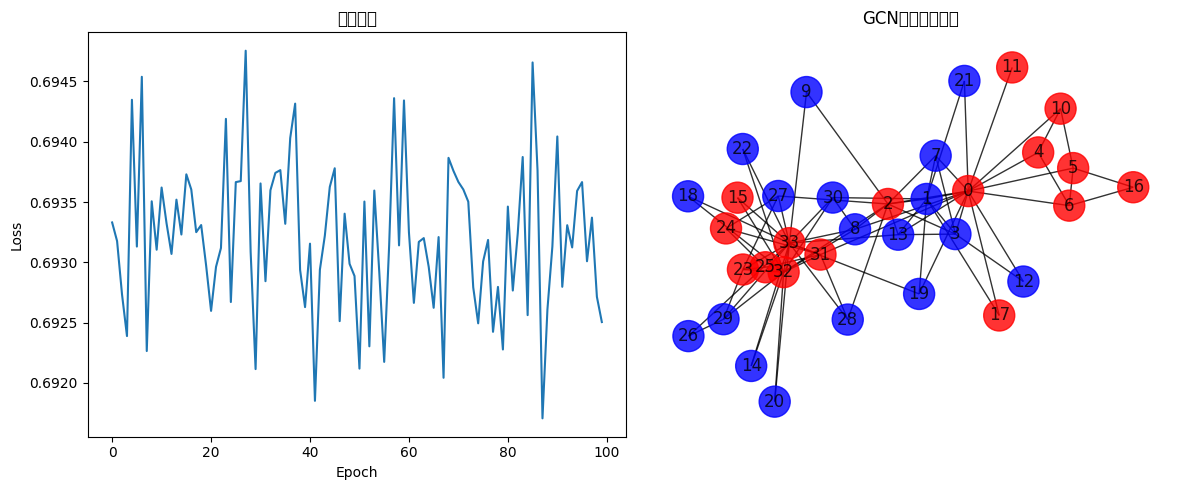

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ============================================================
# 1. 数据处理
# ============================================================

# 1.1 图表示：邻接矩阵
G = nx.karate_club_graph()  # 空手道俱乐部，无向图
num_nodes = G.number_of_nodes()
edges = list(G.edges())

# 手动构建邻接矩阵
A = np.zeros((num_nodes, num_nodes))
for edge in edges:
    i, j = edge
    A[i, j] = 1
    A[j, i] = 1  # 无向图需要添加双向连接
# 简化方法: A = nx.to_numpy_array(G)

# 1.2 添加自环
# 图卷积需要节点自己与自己连接，确保节点在聚合时包含自身信息
A_hat = A.copy()
for i in range(num_nodes):
    A_hat[i, i] = 1
# 简化方法: A_hat = A + np.eye(A.shape[0])

# 1.3 图归一化
# GCN使用对称归一化的邻接矩阵: A_norm = D^(-1/2) A_hat D^(-1/2)
# 计算度矩阵
D_hat = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    degree = 0
    for j in range(num_nodes):
        degree += A_hat[i, j]
    D_hat[i, i] = degree

# 计算D^(-1/2)
D_hat_inv_sqrt = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    D_hat_inv_sqrt[i, i] = 1 / np.sqrt(D_hat[i, i])

# 计算归一化邻接矩阵 D^(-1/2) A_hat D^(-1/2)
temp = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        for k in range(num_nodes):
            temp[i, j] += D_hat_inv_sqrt[i, k] * A_hat[k, j]

A_norm = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        for k in range(num_nodes):
            A_norm[i, j] += temp[i, k] * D_hat_inv_sqrt[k, j]
# 简化方法: 
# D_hat_inv_sqrt = np.linalg.inv(np.sqrt(D_hat))
# A_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

# 1.4 节点特征初始化
# 简单起见，使用单位矩阵作为节点特征（每个节点有一个独热编码特征）
X = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    X[i, i] = 1.0
    
# 1.5 节点标签定义（示例：假设前17个节点属于类别0，后面属于类别1）
y_true = np.zeros(num_nodes)
for i in range(17, num_nodes):
    y_true[i] = 1
    
# 1.6 训练/验证/测试集划分（简单划分示例）
np.random.seed(42)
indices = np.random.permutation(num_nodes)
train_size = int(num_nodes * 0.6)
val_size = int(num_nodes * 0.2)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

# ============================================================
# 2. 前向传播
# ============================================================

# 2.1 前向传播函数（卷积函数）
def manual_matrix_multiply(A, B):
    """手动实现矩阵乘法"""
    rows_A, cols_A = A.shape
    rows_B, cols_B = B.shape
    
    if cols_A != rows_B:
        raise ValueError("矩阵维度不匹配")
    
    result = np.zeros((rows_A, cols_B))
    
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i, j] += A[i, k] * B[k, j]
    
    return result

# 2.2 激活函数
def manual_relu(x):
    """手动实现ReLU激活函数"""
    result = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            result[i, j] = max(0, x[i, j])
    return result

# 2.3 Dropout实现
def manual_dropout(x, dropout_rate=0.5, is_training=True):
    """手动实现Dropout"""
    if not is_training:
        return x
    
    result = np.copy(x)
    mask = np.random.rand(*x.shape) > dropout_rate
    result = result * mask
    # 缩放保持期望值一致
    result = result / (1 - dropout_rate)
    return result

# 2.4 Softmax函数
def manual_softmax(x):
    """手动实现Softmax函数（带数值稳定性处理）"""
    result = np.zeros_like(x)
    
    for i in range(x.shape[0]):
        # 数值稳定性：减去每行最大值
        row_max = np.max(x[i])
        exp_x = np.zeros(x.shape[1])
        exp_sum = 0
        
        # 计算指数和总和
        for j in range(x.shape[1]):
            exp_x[j] = np.exp(x[i, j] - row_max)
            exp_sum += exp_x[j]
        
        # 归一化
        for j in range(x.shape[1]):
            result[i, j] = exp_x[j] / exp_sum
            
    return result

# 2.5 GCN前向传播
def manual_gcn_forward(X, A_norm, W1, W2, is_training=True):
    """GCN前向传播函数"""
    # 第一层: H = ReLU(A_norm @ X @ W1)
    XW1 = manual_matrix_multiply(X, W1)
    AXW1 = manual_matrix_multiply(A_norm, XW1)
    H = manual_relu(AXW1)
    H = manual_dropout(H, dropout_rate=0.5, is_training=is_training)
    
    # 第二层: Y = A_norm @ H @ W2
    HW2 = manual_matrix_multiply(H, W2)
    Y = manual_matrix_multiply(A_norm, HW2)
    
    return Y, H  # 返回输出和中间层激活值

# ============================================================
# 3. 反向传播
# ============================================================

# 3.1 损失函数
def manual_cross_entropy(y_pred, y_true):
    """手动实现交叉熵损失函数"""
    n_samples = y_pred.shape[0]
    loss = 0.0
    
    for i in range(n_samples):
        true_class = int(y_true[i])
        # 防止数值为0导致的log错误
        p = max(y_pred[i, true_class], 1e-15)
        loss -= np.log(p)
        
    return loss / n_samples

# 3.2 参数更新
def manual_sgd_update(W, gradient, learning_rate):
    """手动实现SGD参数更新"""
    return W - learning_rate * gradient

# 3.3 梯度计算和参数更新
def compute_gradients(X, A_norm, W1, W2, H, Y, y_true, learning_rate=0.01):
    """计算梯度并更新参数"""
    n_samples = Y.shape[0]
    
    # 将Y转换为概率
    probs = manual_softmax(Y)
    
    # 计算输出层的梯度
    dY = np.copy(probs)
    for i in range(n_samples):
        true_class = int(y_true[i])
        dY[i, true_class] -= 1
    dY /= n_samples  # 平均梯度
    
    # 计算W2的梯度
    AH = manual_matrix_multiply(A_norm, H)
    dW2 = manual_matrix_multiply(AH.T, dY)
    
    # 反向传递到隐藏层
    dH = manual_matrix_multiply(dY, W2.T)
    dH = manual_matrix_multiply(A_norm.T, dH)
    
    # ReLU梯度
    dH_relu = np.zeros_like(H)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i, j] > 0:
                dH_relu[i, j] = dH[i, j]
    
    # 计算W1的梯度
    AX = manual_matrix_multiply(A_norm, X)
    dW1 = manual_matrix_multiply(AX.T, dH_relu)
    
    # 更新权重
    W1_new = manual_sgd_update(W1, dW1, learning_rate)
    W2_new = manual_sgd_update(W2, dW2, learning_rate)
    
    return W1_new, W2_new

# ============================================================
# 4. 模型训练与评估
# ============================================================

# 4.1 初始化模型参数
hidden_dim = 8  # 隐藏层维度
output_dim = 2  # 输出维度（二分类）
np.random.seed(42)  # 设置随机种子以便结果可复现

# 初始化权重（缩小初始权重以避免梯度爆炸）
W1 = np.random.randn(num_nodes, hidden_dim) * 0.1
W2 = np.random.randn(hidden_dim, output_dim) * 0.1

# 4.2 训练循环
num_epochs = 100
learning_rate = 0.01
losses = []

print("开始训练...")
for epoch in range(num_epochs):
    # 前向传播
    Y, H = manual_gcn_forward(X, A_norm, W1, W2, is_training=True)
    
    # 计算损失
    probs = manual_softmax(Y)
    loss = manual_cross_entropy(probs, y_true)
    losses.append(loss)
    
    # 计算梯度并更新参数
    W1, W2 = compute_gradients(X, A_norm, W1, W2, H, Y, y_true, learning_rate)
    
    # 每10个epoch打印一次损失
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# 4.3 模型评估
# 使用训练好的权重进行前向传播
final_Y, _ = manual_gcn_forward(X, A_norm, W1, W2, is_training=False)
final_probs = manual_softmax(final_Y)

# 计算预测结果
predicted = np.zeros(num_nodes)
for i in range(num_nodes):
    if final_probs[i, 1] > final_probs[i, 0]:
        predicted[i] = 1

# 手动计算总体准确率
correct = 0
for i in range(num_nodes):
    if predicted[i] == y_true[i]:
        correct += 1
accuracy = correct / num_nodes

print(f"总体准确率: {accuracy:.4f}")

# 手动计算训练集、验证集和测试集准确率
train_acc = sum(predicted[train_idx] == y_true[train_idx]) / len(train_idx)
val_acc = sum(predicted[val_idx] == y_true[val_idx]) / len(val_idx)
test_acc = sum(predicted[test_idx] == y_true[test_idx]) / len(test_idx)

print(f"训练集准确率: {train_acc:.4f}")
print(f"验证集准确率: {val_acc:.4f}")
print(f"测试集准确率: {test_acc:.4f}")

# ============================================================
# 5. 可视化结果
# ============================================================

# 5.1 损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("训练损失")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# 5.2 节点分类结果可视化
plt.subplot(1, 2, 2)
colors = ['red' if p == 0 else 'blue' for p in predicted]
nx.draw(G, with_labels=True, node_color=colors, node_size=500, alpha=0.8)
plt.title("GCN社区检测结果")

plt.tight_layout()
plt.show()


### GCN核心原理整理
- **基本思想**：通过图结构传递和聚合邻居信息来更新节点表示
- **核心公式**：$$H^{(l+1)} = \sigma(\hat{A}H^{(l)}W^{(l)})$$
  - $\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ 是归一化邻接矩阵
    - **这就是区别于传统深度学习的点，我们用一个保留了整个图的拓扑结构的矩阵通过左乘进入前向传播过程中，但是这就将传统的深度学习的算法复杂度从$O(n^2)$升级到了$O(n^3)$**
  - $H^{(l)}$ 是第l层的节点特征
  - $W^{(l)}$ 是第l层的权重矩阵

### 感受野
- **1层GCN**：节点只能看到直接邻居信息（1-hop）
- **2层GCN**：可以看到邻居的邻居（2-hop）
  - 因为在上一层我们将节点的邻居信息聚合进了邻居的信息中
- **L层GCN**：理论上可以聚合L跳范围内所有节点信息

### 过平滑问题
- **定义**：随着层数增加，不同节点的表示会趋于相似（因为如果层次很多其实每个节点都聚合了全图信息）
  - 所以通常简单的任务就只有三层
- **原因**：多次图拉普拉斯平滑等效于随机游走
  - 为啥说多次图拉普拉斯呢？因为我们进入前向传播的$hat{A}$就是应用了拉普拉斯归一化，每一层前向传播，我们就重复了一次。并且我们很大程度上依赖于这个拉普拉斯归一化，因为我们不想极端节点的影响过大
- **解决方案**：残差连接、跳跃连接、注意力机制、Dropout

### 图空间特性
- **非欧几里得**：没有固定坐标系，关系由连接决定
- **距离度量**：最短路径距离、随机游走距离、扩散距离
- **图信号**：定义在节点上的函数（如特征）
- **谱理论**：邻接矩阵特征分解揭示图的频率特性

## 实现关键步骤（核心组件）

### 1. 图结构处理
- **邻接矩阵构建**：根据边集合生成邻接矩阵
- **自环添加**：确保节点在聚合时包含自身信息
- **对称归一化（拉普拉斯归一化）**：$\hat{A} = D^{-\frac{1}{2}}(A+I)D^{-\frac{1}{2}}$

### 2. 消息传递机制
- **信息聚合**：$\hat{A} \cdot X$ 实现从邻居收集信息
- **特征变换**：$(\hat{A} \cdot X) \cdot W$ 将聚合后信息映射到新空间
- **非线性激活**：应用ReLU等激活函数引入非线性

### 3. 训练与优化
- **损失函数**：节点分类通常使用交叉熵损失
- **参数更新**：计算梯度并使用优化器更新权重
- **正则化**：Dropout、L2正则化防止过拟合

## 不同任务的扩展

### 节点分类
- **保持组件**：GCN基本结构不变
- **输出层**：类别数量对应输出维度
- **损失函数**：交叉熵或NLL损失
- **评估指标**：准确率、F1分数

### 链接预测
**但是我前几天看到一片paper其实就是washu毕业的一个博士师兄Muhan Zhang写的应用于链接预测的新范式Seal**
- **替换组件**：
  - **节点表示获取**：仍使用GCN
  - **添加组件**：节点对表示函数 
    - Muhan Zhang 2018 已经将这个问题简化为子图级别的任务
  - **修改输出**：二元分类器预测边存在概率
- **节点对表示方法**：
  - 拼接：$[h_i, h_j]$
  - 哈达玛积：$h_i \odot h_j$
  - 距离函数：$|h_i - h_j|$
- **损失函数**：二分类交叉熵

### 图分类
- **替换组件**：
  - **保持**：节点级GCN层
  - **添加**：图池化层（聚合节点表示）
    - 所谓的池化就是在GCN层后面加一个筛选节点的函数，保留部分最优用的信息
  - **修改**：处理多图数据结构
- **池化方法**：
  - **均值池化**：$h_G = \frac{1}{|V|}\sum_{v \in V} h_v$
  - **最大池化**：$h_G = \max_{v \in V} h_v$
  - **差分池化**：学习节点聚类并分层池化
- **损失函数**：图标签的交叉熵

### 节点聚类
- **替换组件**：
  - **保持**：GCN结构
  - **修改**：无监督/自监督损失函数
  - **添加**：聚类算法（K-means等）
- **损失函数**：
  - 重构损失：$\|A - ZZ^T\|_F^2$
  - 对比损失：拉近相似节点，推远不同节点
- **评估指标**：聚类系数、模块度

### 图生成
- **替换架构**：
  - **编码器**：GCN提取节点表示
  - **添加**：VAE或GAN生成架构
  - **解码器**：从潜在空间重构图
- **损失函数**：
  - 重构损失
  - KL散度正则化（VAE）或对抗损失（GAN）

## 高级技术

### 图注意力网络(GAT)
- **替换组件**：固定邻接矩阵→学习注意力权重
- **优势**：自适应分配不同邻居的重要性
- **公式**：$h_i = \sigma(\sum_{j \in \mathcal{N}(i)} \alpha_{ij} W h_j)$

### 异构图神经网络
- **替换组件**：
  - 多类型邻接矩阵
  - 关系特定的转换矩阵
- **消息传递**：根据节点/边类型采用不同聚合方式

### 图变换器(Graph Transformer)
- **替换组件**：邻居聚合→自注意力机制
  - 前向传播的$hat{A}$就被替换成了查询、键、值矩阵
- **添加**：位置编码捕获图结构信息
- **优势**：全局依赖关系建模、并行计算

### 时序图神经网络
- **添加组件**：
  - GNN处理空间依赖
  - RNN/时序注意力处理时间依赖
- **应用**：动态图、时间序列预测

## 实现技巧

### 提高GNN性能
- **特征工程**：添加节点度、中心性等拓扑特征
- **残差连接**：$H^{(l+1)} = \sigma(\hat{A}H^{(l)}W^{(l)}) + H^{(l)}$
- **批归一化**：加速训练并提高稳定性
- **采样技术**：邻居采样、层采样减少计算开销

### 处理大规模图
- **图采样**：随机游走、节点/边采样构建小批量
- **图分区**：将大图分解为多个子图并行处理
- **分布式训练**：跨多GPU/机器训练

### 模型评估
- **划分策略**：随机、时间或结构感知的划分
- **归纳设置**：测试包含训练中未见过的节点
- **易错点**：避免信息泄露，保持图结构完整
